# **LLM Zoomcamp 2024 Competition**
### **Author:  [🅱🅻🅰🆀 ](https://www.linkedin.com/in/chinonsoodiaka/)**


Welcome to my final submission for the [LLM Zoomcamp 2024 Competition](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/overview) hosted by [DataTalksClub](https://datatalks.club/). This notebook showcases an agentic approach to solving complex mathematics problems using Large Language Models (LLMs).

### **To Begin**

I will install necessary python packages.

In [ ]:
! pip install -qU langchain_huggingface \
langchain_community\
langchain_openai\
langchain_groq\
langchainhub\
langgraph

I will load my environment keys.

If you are running this on Colab:

In [8]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

Or uncomment and run code below if you have a ```.env``` file:

```
OPENAI_API_KEY=...
GROQ_API_KEY=...

```

In [1]:
#from dotenv import load_dotenv
#load_dotenv()

True

### **Implementation**

Now, I will define the key components of my application. My goal is to create, using LangGraph, an agent with tools that can correctly answer all the varying mathematical concepts represented by the [dataset](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/data). In simpler terms, to have a score of **100** on the [Leaderboard](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/leaderboard).

##### **Tools**

First tool, a simple math tool:

In [2]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

@tool
def simple_math_tool(messages: str) -> str:
    """
    Solve a basic arithmetic problem by generating a Python solution.
    
    Args:
        messages (str): The simple math problem statement.
        
    Returns:
        messages(str): The Python code that solves the problem.
    """
    # Define the prompt template for solving simple math problems
    solve_simple_prompt = PromptTemplate(
        template="""\
You are skilled at solving basic arithmetic problems. Given the following problem, provide a clear and concise solution with an executable python script.


Problem: {messages}

Solution (executable python script):
Make sure your solution is accurate and straightforward. Avoid any extra commentary or unnecessary details.
""",
        input_variables=["messages"],
    )

    # Initialize the LLM for solving simple problems
    llm = ChatOpenAI(temperature=0.1, model_name="gpt-4o")
    simple_solver = solve_simple_prompt | llm | StrOutputParser()
    
    # Generate the solution
    ans = simple_solver.invoke({"messages": messages})
    return {"messages": ans}


Next tool, word problems:

In [3]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

@tool
def word_problems(messages: str) -> str:
    """
    Solve a logical problem by generating a detailed Python solution.
    
    Args:
        messages (str): The logical problem statement.
        
    Returns:
        messages (str): The Python code that solves the problem.
    """
    # Define the prompt template for solving logical problems
    solve_logic_prompt = PromptTemplate(
        template="""\
You are an expert at solving logical and algorithmic problems. Given the following problem, provide a clear and detailed solution with an executable python script.

Problem: {messages}

Solution (executable python script):
Ensure that your solution is precise and correctly addresses all aspects of the problem. Avoid adding unnecessary explanations.
""",
        input_variables=["messages"],
    )

    # Initialize the LLM for solving logical problems
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
    logic_solver = solve_logic_prompt | llm | StrOutputParser()
    
    # Generate the solution
    ans = logic_solver.invoke({"messages": messages})
    return {"messages": ans}

Final tool, a complex tool:

In [4]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

@tool
def complex_tool(messages: str) -> str:
    """
    Solve a complex math problem by generating a detailed Python solution.
    
    Args:
        messages (str): The complex math problem statement.
        
    Returns:
        messages (str): The Python code that solves the problem.
    """
    # Define the prompt template for solving complex problems
    solve_others_prompt = PromptTemplate(
        template="""\
You are an expert at solving complex and intricate math problems that do not fit into basic arithmetic or word problems. Given the following problem, provide a clear,
detailed, and accurate python solution with an executable python script.

Problem: {messages}

Solution (executable python script):
Please ensure that your explanation is thorough and your solution is correct. Avoid any preamble or extra sentences. Make sure to carefully address all aspects of the problem
to provide a comprehensive python solution with script.
""",
        input_variables=["messages"],
    )

    # Initialize the LLM for solving complex problems
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
    others_solver = solve_others_prompt | llm | StrOutputParser()
    
    # Generate the solution
    ans = others_solver.invoke({"messages": messages})
    return {"messages": ans}

Now I am done creating my tools. I will create my assistant:

##### **Assistant**

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
tools = [word_problems, simple_math_tool, complex_tool]
llm_with_tools = llm.bind_tools(tools)

Now a little prompt engineering and then initialize the assistant:

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content = """

You are a helpful math assistant with access to 3 tools: word_problems, simple_math_tool, complex_tool. First you route the query to 
one of the tools. 
###Examples:
   1. **simple_math_tool**: Problems that involve straightforward calculations or logical reasoning using basic mathematical operations such as addition, subtraction, multiplication, and division. These problems may also include simple scenarios requiring basic inference from provided data.
   
   - Example: "In parallelogram \(ABCD\), the diagonals are the bisectors of its angles, \(AB = 34\), \(AC = 32\). Find \(BD\)."
   - Example: "Find a four-digit number that is a multiple of 24, the product of whose digits is 16. In your answer, provide any one such number."
   - Example: "Find the value of the expression \\(4.8 \\cdot 2.5\\)."
   - Example: "Pavel Ivanovich bought an American car, the speedometer of which shows the speed in miles per hour. What is the speed of the car in kilometers per hour if the speedometer shows 46 miles per hour? Assume that 1 mile is equal to 1609 meters. Round the answer to the nearest whole number."
   - Example: "Masha and the Bear ate 51 cookies and a jar of jam, starting and finishing at the same time. At first, Masha was eating the jam, and the Bear was eating the cookies, but at some point, they switched. The Bear eats both four times faster than Masha. How many cookies did the Bear eat if they ate the jam equally?"
   - Example: "Find the root of the equation: \\(\\left(\\dfrac{{1}}{{8}} \\right)^{{4 - x}} = 64\\)."
   - Example: "Some 11th-grade students from the school went on a trip to Nizhny Novgorod in the fall. In the spring, some 11th-grade students will go to Kazan, and none of those who went to Nizhny Novgorod in the fall will be among them. Select the statements that will be true under the given conditions regardless of who among the 11th graders will go to Kazan.  \begin{center} \begin{tabularx}{\textwidth}{p{0.1cm}X}  1) & There is not a single 11th grader who went on a trip to Nizhny Novgorod and will go to Kazan. \\  2) & Every 11th grader who did not go on a trip to Nizhny Novgorod will go to Kazan.  \\  3) & There will be an 11th grader who did not go on a trip to Nizhny Novgorod and will not go to Kazan. \\  4) & Among the 11th-grade students of this school who will not go to Kazan, there is at least one who went on a trip to Nizhny Novgorod.  \\  \end{tabularx} \end{center}  In the answer, write down the numbers of the selected statements without spaces, commas, or other additional symbols."
   - Example: "A construction contractor plans to buy 20 tons of facing bricks from one of three suppliers. Each brick weighs 5 kg. The price of the brick and the delivery terms for the entire purchase are shown in the table. What is the cost in rubles of the cheapest purchase option including delivery?"
   - Example: "A chocolate bar costs 20 rubles. On Sundays, the supermarket has a special offer: if you pay for two chocolate bars, you get three (one as a gift). How many chocolate bars can you get for 150 rubles on Sunday?"
   - Example: "Each of the four inequalities in the left column corresponds to one of the solutions in the right column. Establish the correspondence between the inequalities and their solutions.
   \begin{{center}}
\renewcommand{{\arraystretch}}{{1.5}}
\begin{{tabularx}}{{\textwidth}}{{>{{\raggedright\arraybackslash}}X>{{\centering\arraybackslash}}X}}
\multicolumn{{1}}{{c}}{{INEQUALITIES}} & \multicolumn{{1}}{{c}}{{SOLUTIONS}} \\
A) $x^{{2}} -9x+20\ge 0$ & 1) $-10\le x \le 2$ \\
B) $x^{{2}} -8x-20\le 0$ & 2) $x\le -5$ or $x \ge -4$ \\
C) $x^{{2}} +9x+20\ge 0$ & 3) $-2\le x \le 10$ \\
D) $x^{{2}} +8x-20\le 0$ & 4) $x \le 4$ or $x \ge 5$ \\
\end{{tabularx}}
\end{{center}}

Write the corresponding solution number under each letter in the provided table.

\begin{{center}}
\begin{{tabular}}{{|*{{4}}{{c|}}}} \hline A & B & C & D \\ \hline & & &  \\ \hline
\end{{tabular}}
\end{{center}}"

   - Example: "Match the functions with the characteristics of these functions on the interval \\([0;5]\\).

\begin{{center}}
\begin{{tabularx}}{{\textwidth}}{{clcX}} 
\multicolumn{{2}}{{c}}{{FUNCTIONS}} & \multicolumn{{2}}{{c}}{{CHARACTERISTICS}} \\ 
A) & $y=2x-3$ & 1) & increasing function \\ 
B) & $y=x^2-x+2$ &  2) & decreasing function \\ 
C) & $y=4x-x^2$  & 3) & the function has a minimum point \\ 
D) & $y=5-3x$  &  4) & the function has a maximum point    \\ 
\end{{tabularx}}
\end{{center}}

In the table below, write the corresponding number under each letter.

\begin{{center}}
\begin{{tabular}}{{|*{{4}}{{c|}}}} \hline 
 A & B & C & D \\ \hline 
& & & \\ \hline
\end{{tabular}}
\end{{center}}"
2. **word_problems**: Problems presented in a narrative form, requiring the solver to extract and use mathematical concepts to find the solution, often involving real-world scenarios.
   - Example: "The plane's navigation system informs the passenger that the flight is at an altitude of 37,000 feet. Express the flight altitude in meters. Assume that 1 foot is equal to 30.5 cm."
   - Example: "At the school, there are two-person camping tents. What is the minimum number of tents needed for a trip involving 25 people?"
3. **Complex**: Problems that do not fit neatly into the previous two categories, often involving more complex concepts or requiring multiple steps and different types of reasoning.
   - Example: "Sixteen teams are participating in the World Championship, including the team from Canada. They need to be divided into four groups of four teams each by drawing lots. The box contains mixed cards with group numbers: 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4. The team captains draw one card each. What is the probability that the team from Canada will end up in the fourth group?"
   - Example: "The volume of a rectangular parallelepiped is calculated using the formula \\(V=abc\\), where \\(a\\), \\(b\\), and \\(c\\) are the lengths of the three edges meeting at one vertex. Using this formula, find \\(a\\) if \\(V=70\\), \\(b=5\\), and \\(c=3.5\\)."
   - Example: "The chef baked 40 cookies, of which he sprinkled 10 cookies with cinnamon and 20 cookies with sugar. Choose the statements that are true under the given conditions."
   


                        
                        
                        
                        
                        
Next, you look at the output of the tool and print only the generated python code in a markdown format. 

                        
If the user asks flirty, intimate, or sensitive questions related to topics like emotions or religion, respond ONLY with:
"I'm sorry, but let us keep the conversation strictly about math."

""")


# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Now to put it all together in a graph:

##### **Graph**

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

Display graph:

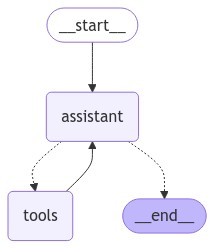

In [8]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

To try it out:

In [9]:
# Specify a thread. (Not necessary)
config = {"configurable": {"thread_id": "0"}}

# Specify an input
messages = [HumanMessage(content=input("Enter your query here: "))]

# Run
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

"Establish a correspondence between the quantities and their possible values: match each element from the first column with the corresponding element from the second column.  \vspace{\medskip}  \begin{center} \hyphenpenalty=10000 \begin{tabular}{p{8cm}p{5cm}} QUANTITIES & VALUES \\ A) mass of an adult whale & 1) 162 sq. m\\ B) volume of a railway car & 2) 100 t\\ C) area of a volleyball court & 3) 120 m$^{3}$\\ D) width of a football field & 4) 68 m \\ \end{tabular}\end{center}  \vspace{\medskip}  In the table, under each letter corresponding to a quantity, indicate the number of its possible value.  \vspace{\medskip}  \begin{tabular}{|c|c|c|c|} \hline A & B & C & D \\ \hline  &  &  &  \\ \hline \end{tabular}"
================================== Ai Message ==================================
Tool Calls:
  simple_math_tool (call_Yj4cNx19HSd11anMDcE8Vid3)
 Call ID: call_Yj4cNx19HSd11anMDcE8Vid3
  Args:
    me

Instead of running the generated script in a cell directly, I will use the following couple of helper functions to execute the generated scripts:

In [10]:
import io
import contextlib

* ```extract_code()```

In [11]:
def extract_code(output):
    # Find the start and end positions of the code block
    start = output.find("```python") + len("```python")
    end = output.find("```", start)
    
    # Extract the code between the found positions
    code_block = output[start:end].strip()
    
    return code_block

In [12]:
code = extract_code(messages["messages"][-1].content)
code

* ```execute_Python_code()```

In [13]:
def execute_Python_code(code):
      # A string stream to capture the outputs of exec
      output = io.StringIO()
      try:
          # Redirect stdout to the StringIO object
          with contextlib.redirect_stdout(output):
              # Allow imports
              exec(code, globals())
      except Exception as e:
          # If an error occurs, capture it as part of the output
          print(f"Error: {e}", file=output)
      return output.getvalue()

In [14]:
print(execute_Python_code(code))

A) mass of an adult whale -> 2) 100 t
B) volume of a railway car -> 3) 120 m³
C) area of a volleyball court -> 1) 162 sq. m
D) width of a football field -> 4) 68 m



### **Testing**

Alright, time to run the entire test dataset.

First, download the test dataset [here](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/data?select=test.csv).

Then, load the dataset:

In [15]:
import pandas as pd 

# Load the dataset
test_df = pd.read_csv('test.csv')

To present the final response from the app in the expected format (based on competition instructions and observation after manually inspecting the train dataset):

In [17]:
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Define the prompt template 
prompt = PromptTemplate(
    template="""
Analyze the provided context and determine the answer in numerical format based on the following guidelines:

1. **Format of Response**: 
   - For matching problems, respond with the correct numerical sequence as instructed in the context.
   - For mathematical expressions, provide the numerical answer rounded to one decimal place, if required.
   - For probabilities or percentages, format the response to two decimal places.

2. Provide only the numerical answer according to the guidelines, without spaces between digits. Do not perform any calculations or solve the problem; 
   focus solely on interpreting the context and formatting the response as required.

3. **Examples**:
   Question: "Match the quantities and values: \\begin{{tabular}}{{p{{8cm}}p{{5cm}}}} QUANTITIES & VALUES \\\\ A) mass of an adult whale & 1) 162 sq. m\\\\ B) volume of a railway car & 2) 100 t\\\\ C) area of a volleyball court & 3) 120 m$^{{3}}$\\\\ D) width of a football field & 4) 68 m \\\\ \\end{{tabular}}  Indicate the number under each letter."
   Context: "\\begin{{tabular}}{{|c|c|c|c|}} \\hline A & B & C & D \\\\ \\hline 2 & 3 & 1 & 4 \\\\ \\hline \\end{{tabular}}"
   Expected output: 2314

**Question**: {question}
**Provided Context**: {context}
""",
    input_variables=["question", "context"]
)

# Initialize the LLM
llm = ChatOpenAI(temperature=0.1, model_name="gpt-4o")

# Chain the prompt with the LLM and output parser
response_chain = prompt | llm | StrOutputParser()

I will provide a progress bar for the automation using ```tqdm```.

In [18]:
! pip install -qU tqdm

The automation:

I will use 6 threads to make concurrent requests to the API.

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

# Function to process each row
def process_row(row):
    problem_text = row['problem_text']
    messages = [HumanMessage(content=problem_text)]
    
    # Call the react_graph to generate an AI response
    response_messages = react_graph.invoke({"messages": messages})
    
    # Extract the question and the Python code from the AI response
    question = response_messages['messages'][0].content
    ai_response = response_messages['messages'][-1].content
    code = extract_code(ai_response)
    
    # Execute the Python code to get the raw answer
    raw_answer = execute_Python_code(code)
    
    # Generate the final validated answer
    final_answer = generate_final_answer(question, raw_answer)
    
    # Return the result as a dictionary
    return {'problem_id': row['problem_id'], 'answer': final_answer}

# Function to generate final validated answer
def generate_final_answer(question, raw_answer):
    response = response_chain.invoke({"question": question, "context": raw_answer})
    return response

# Create or load the results CSV file
results_file = 'submission.csv'
try:
    results_df = pd.read_csv(results_file)
except FileNotFoundError:
    results_df = pd.DataFrame(columns=['problem_id', 'answer'])

# Initialize an empty list to store the future results
futures = []

# Run the processing with multiple workers
with ThreadPoolExecutor(max_workers=6) as executor:
    # Submit all tasks and track progress
    futures = {executor.submit(process_row, row): row for _, row in test_df.iterrows()}
    
    for future in tqdm(as_completed(futures), total=len(test_df), desc="Processing"):
        # Get the result from each future
        result = future.result()
        
        # Append the result to the DataFrame
        df = pd.DataFrame({'problem_id': [result['problem_id']], 'answer': [result['answer']]})
        results_df = pd.concat([results_df, df], ignore_index=True)

# Save the results to the CSV file
results_df.to_csv(results_file, index=False)

print(f"Results have been saved to {results_file}")

Processing: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it]

Results have been saved to submission.csv


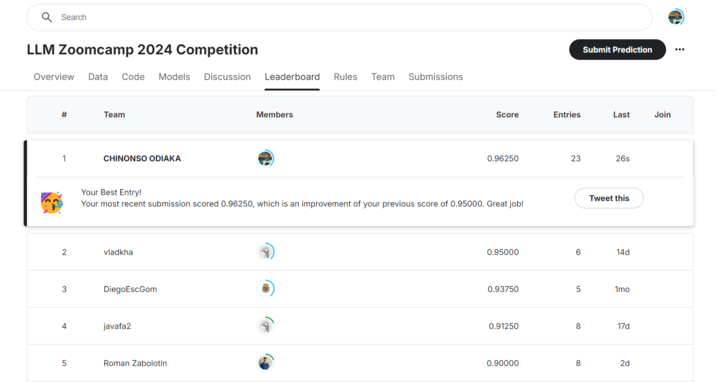

# **Conclusion**


Important Note:
* If you encounter an "Internal Error" message, wait for a minute and try re-running the query.

I'm open to any suggestions on how to improve this process in the future.

Remarks:


What a journey it has been to reach a score of **96.25%**! While the goal was to hit 100%, I might need to explore a paid mathematics API like [Wolfram Alpha](https://www.wolfram.com/products/) for that final push. Fortunately, LangChain offers integration with Wolfram Alpha. However, subscribing to their service would cost around 10 USD per month, and I've already invested a significant amount of money in this project. Although Wolfram Alpha has a free tier, it only achieved around 75% accuracy in my tests. 

Despite not reaching 100%, I'm grateful for the experience and here are my key findings:

* **Cost**:
The state-of-the-art models that performed best for this dataset are OpenAI's **GPT-4o**, Meta's **llama-3.1-70b**, and Anthropic's **claude-3-5-sonnet**, in that order. Each of these models can individually achieve around a 91% score on the [Leaderboard](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/leaderboard). To maximize performance, I implemented an agent using LangGraph that leveraged more than one of these models. However, running agentic systems can be expensive. I ultimately decided to exclude Sonnet because it didn't answer any questions correctly that the other two models couldn't handle. The remaining two models provided complementary strengths, and running the entire test dataset once costs about **3 USD**.

* **Inference**:
There's a rate limit on how many queries you can send to the Groq API per minute, which can slow down the inference process. However, using Groq means I don't have to manage a large-scale LLM infrastructure myself. If you encounter an internal error, it's not due to something being broken—it's simply a matter of throttling. Waiting for about 60 seconds before retrying usually resolves the issue.

* **Performance**:
Achieving 96.25% is impressive. There's a lot of optimism around LLMs, particularly regarding their reasoning, math, and computational abilities, and this result supports that optimism. What impressed me most was the leap in reasoning capabilities from GPT-3.5 Turbo to the current models. This improvement was reflected in the leaderboard scores for this competition and was more exciting than the incremental progress from 90% to 96.25% using agents. While agents show a lot of promise, they are still somewhat unreliable. I appreciate LangChain's efforts in providing the community access to **LangGraph**; a low-level framework that assists developers in building custom stateful applications, and this is why I used their framework throughout this challenge. On the flip side, I was somewhat disappointed with the performance of GPT-4o-mini. In terms of reasoning, there's a significant gap between GPT-4o-mini and the original GPT-4o.